In [1]:
%load_ext cuml.accel

[2025-03-21 04:18:39.350] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-21 04:18:39.351] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
import anndata
import plotnine as p
from sklearn.manifold import TSNE
import scvi

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!


In [3]:
adata = anndata.io.read_h5ad(
    '/teamspace/studios/scratch-studio/data/AIDA Phase 1 Freeze 1/250310.sampled.h5ad'
)
    
adata

AnnData object with n_obs × n_vars = 103811 × 36161
    obs: 'mapped_reference_assembly', 'alignment_software', 'library_uuid', 'assay_ontology_term_id', 'library_starting_quantity', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'donor_BMI_at_collection', 'suspension_derivation_process', 'suspension_enriched_cell_types', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Country', 'nCount_RNA', 'nFeature_RNA', 'Ethnicity_Selfreported', 'TCR_VDJdb', 'TCRa_V_gene', 'TCRa_D_gene', 'TCRa_J_gene', 'TCRa_C_gene', 'TCRb_V_gene', 'TCRb_D_gene', 'TCRb_J_gene', 'TCRb_C_gene', 'TCR_Clonality', 'TCR_Clone_ID', 'BCR_VDJ_V_call', 'BCR_VDJ_D_call', 'BCR_VDJ_J_call', 'BCR_VDJ_

In [4]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'donor_id')

In [5]:
model = scvi.model.SCVI(
    adata,
    n_layers = 2,
    encode_covariates = True,
    deeply_inject_covariates = True,
    use_layer_norm = 'both',
    use_batch_norm = 'none',
    gene_likelihood = 'nb'
)

In [6]:
model.train(max_epochs = 20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [7]:
latents = model.get_latent_representation()

emb = TSNE().fit_transform(latents)

model.adata.obs['tsne_1'] = emb[:, 0]
model.adata.obs['tsne_2'] = emb[:, 1]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.


[2025-03-21 04:29:28.454] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 6 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /teamspace/studios/this_studio/250226 Integration/Figures/250320.model.integrated.encoded.donor_id.tsne.png


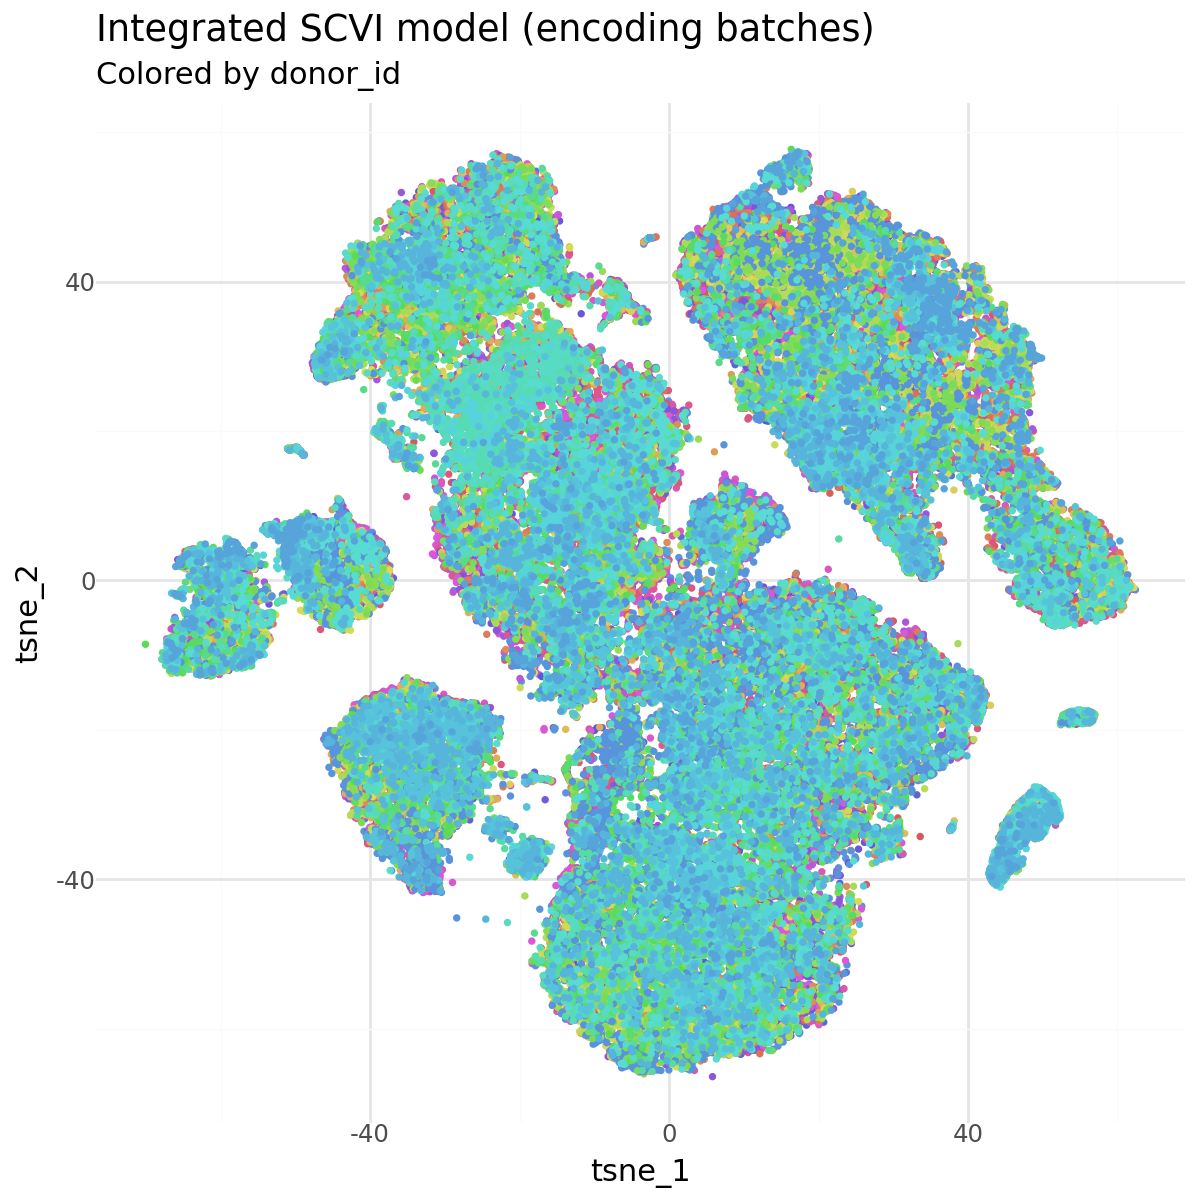

In [14]:
color_by = 'donor_id'
p_ = (
    p.ggplot(p.aes(x = 'tsne_1', y = 'tsne_2', color = color_by), model.adata.obs)
    + p.geom_point(shape = '.')
    + p.coord_equal()
    + p.theme_minimal()
    + p.theme(figure_size = (6, 6), legend_position = 'none')
    + p.labs(title = 'Integrated SCVI model (encoding batches)', subtitle = f'Colored by {color_by}')
)

p_.save(
    '/teamspace/studios/this_studio/250226 Integration/Figures/'
    '250320.model.integrated.encoded.donor_id.tsne.png',
    dpi = 300
)

p_

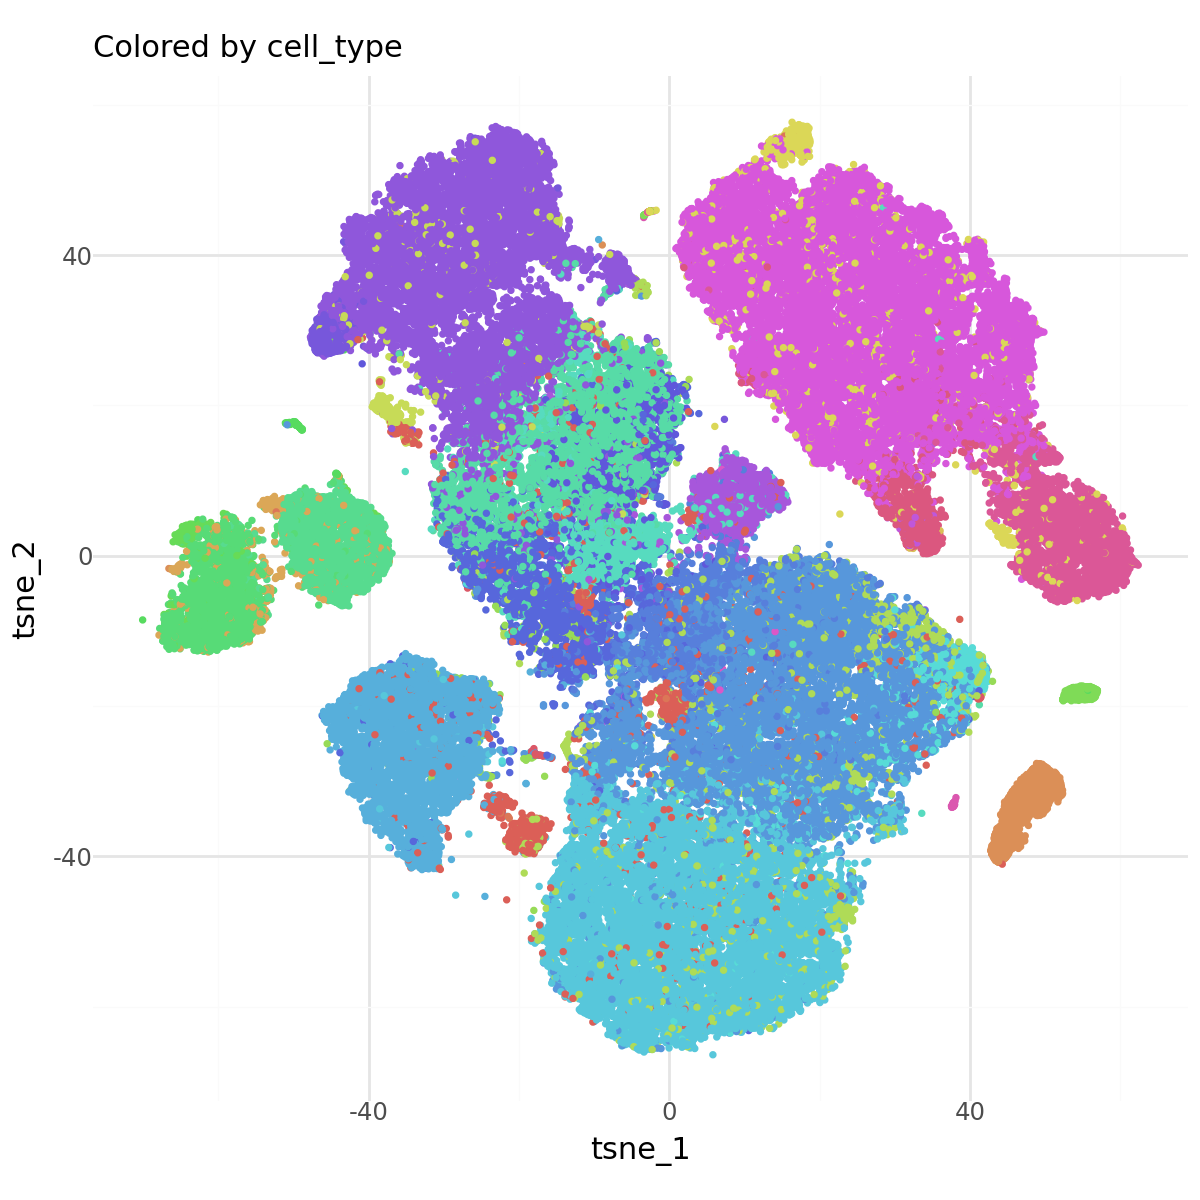

In [8]:
color_by = 'cell_type'
(
    p.ggplot(p.aes(x = 'tsne_1', y = 'tsne_2', color = color_by), model.adata.obs)
    + p.geom_point(shape = '.')
    + p.coord_equal()
    + p.theme_minimal()
    + p.theme(figure_size = (6, 6), legend_position = 'none')
    + p.labs(x = 'tsne_1', y = 'tsne_2', subtitle = f'Colored by {color_by}')
)


In [10]:
model.save(
    '/teamspace/studios/this_studio/data/AIDA Phase 1 Freeze 1/250319.model.enc_cov',
    overwrite = True
)